# Training data preparation

## Background

In machine learning, training data plays a crucial role in training algorithms or models to accurately predict specific outcomes or answers. When it comes to wetland classification, ensuring that the training dataset includes a diverse representation of different wetland types is essential. This is where stratified random sampling comes into play.

Stratified random sampling is a method that takes into account the variations and diversity within wetland areas. By stratifying the sampling process, the aim is to ensure that each wetland type, such as marshes, swamps, or bogs, is proportionately included in the generated samples. This approach is important because it helps to capture the distinct characteristics and patterns associated with each wetland type.

By including representative samples from various wetland types, the resulting wetland classification model becomes more robust and accurate in identifying and classifying different wetland categories. It enables the model to learn and understand the specific features, such as vegetation composition, hydrological characteristics, or soil properties, that define each wetland type.

Additionally, the balanced representation of wetland types in the training dataset helps to mitigate the risk of biases or disproportionate emphasis on certain wetland categories. This ensures a more comprehensive understanding of the overall wetland ecosystem and enhances the model's ability to generalize its classification predictions to unseen data.

## Description

The purpose of this notebook is to generate samples for training a wetland classification model. The notebook focuses on creating representative samples of both wetland and non-wetland areas in order to train an accurate and robust model.

The following steps outline the process:

1. **Load the study area and wetland inventory vectors:** In this step, the study area boundaries and the vector data representing wetland locations are loaded.

2. **Sample wetland and non-wetland areas:** The notebook employs a sampling strategy based on the specific scenario:

    a. **Sampling with wetland types:** If there are multiple wetland types present, the notebook utilizes stratified random sampling. This approach
    proportionately includes samples from each wetland type, capturing the variations and diversity within wetland areas. By considering the
    distinct characteristics of each wetland type, the wetland classification model can accurately classify different wetland categories.

    b. **Sampling without wetland types:** When there is only one wetland type or no wetland types present, random sampling is used. This
    sampling approach ensures a balanced spatial distribution across the study area.
    
    c. **Non-Wetland area:** For non-wetland areas, random sampling is utilised to ensure a balanced spatial distribution across the study area.This means that samples are randomly selected from the available non-wetland areas, taking into account the proportion of non-wetland areas to the total study area. The purpose of this sampling approach is to capture the spatial patterns and characteristics specific to the non-wetland class.
    

3. **Create Combine the wetland and non-wetland samples:** The wetland and non-wetland samples generated from the previous step are combined into a single dataset. This combined dataset will be used for training the wetland classification model. By including both wetland and non-wetland samples, the model can learn to distinguish and classify different types of wetlands accurately.

By following these steps, the notebook creates a comprehensive and balanced training dataset for the wetland classification model, enabling it to accurately identify and classify wetland areas based on their distinct characteristics.

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

## Load Packages

In [1]:
import json
import random

import geopandas as gpd
import numpy as np
from odc.geo.geom import Geometry
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from tqdm import tqdm
from shapely import speedups
from shapely.ops import triangulate
from shapely.strtree import STRtree
from shapely.geometry import Point, Polygon
from sklearn.model_selection import train_test_split
from deafrica_tools.plotting import display_map, map_shapefile, plot_lulc

## Load the study area and wetland inventory vectors

In [2]:
import requests


def load_huc_boundary(huc_id) -> gpd.GeoDataFrame:
    url = "https://hydro.nationalmap.gov/arcgis/rest/services/wbd/MapServer/4/query"
    params = {
        "where": f"HUC8='{huc_id}'",
        "outFields": "*",
        "returnGeometry": "true",
        "f": "geojson",
    }

    response = requests.get(url, params=params)
    response.raise_for_status()
    return response.json()


SKYCOMISH_HUC8_ID = "17110009"
aoi = load_huc_boundary(SKYCOMISH_HUC8_ID)

aoi_geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
aoi_geopolygon_gdf = gpd.GeoDataFrame(geometry=[aoi_geopolygon], crs=aoi_geopolygon.crs)

In [3]:
# Load area of interest vector


def get_nwi(huc8_id: str):
    return gpd.read_file(
        f"/vsizip//vsicurl/https://documentst.ecosphere.fws.gov/wetlands/downloads/watershed/HU8_{huc8_id}_Watershed.zip/HU8_{huc8_id}_Watershed/HU8_{huc8_id}_Wetlands.shp"
    )


SKYCOMISH_HUC8_ID = "17110009"
prefix = SKYCOMISH_HUC8_ID
nwi = get_nwi(SKYCOMISH_HUC8_ID)
nwi.to_file(f"/data/nwi_{SKYCOMISH_HUC8_ID}.gpkg")

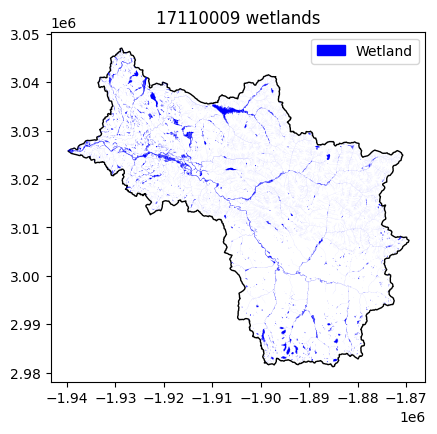

In [4]:
# Load wetland polygons
wetland_inventory_gdf = gpd.overlay(
    nwi, aoi_geopolygon_gdf.to_crs(nwi.crs), how="intersection"
)


# Plot the area of interest (AOI) and the Wetland polygons
fig, ax = plt.subplots()
base = aoi_geopolygon_gdf.to_crs(nwi.crs).plot(ax=ax, color="white", edgecolor="black")
wetland_inventory_gdf.plot(ax=base, marker="o", color="blue", markersize=5)
legend_patch = mpatches.Patch(color="blue", label="Wetland")
plt.title(f"{SKYCOMISH_HUC8_ID} wetlands")
ax.legend(handles=[legend_patch], loc="upper right")
plt.subplots_adjust(bottom=0.15)
plt.show()

## Sample training data 

Sampling wetland points for training data can be approached in two ways, depending on the available data. The two options are:

1. **Sampling with wetland types:** If the wetland data includes information about different types of wetlands (e.g., marshes, swamps, bogs), you can perform sampling while considering the specific wetland types. In this approach, the sampling process takes into account the different wetland types present in the data and aims to obtain representative samples from each wetland type. By ensuring the inclusion of samples from each wetland type, the resulting training data can better capture the characteristics and patterns associated with each wetland type.

2. **Sampling without wetland types:** In cases where the wetland data does not provide information about different wetland types or if wetland types are not applicable to the dataset, the sampling process focuses solely on wetland areas as a whole. This approach disregards the specific wetland types and aims to obtain representative samples from all wetland areas collectively. The goal is to capture the overall characteristics and patterns exhibited by wetland areas, without considering the differentiation between specific wetland types.

### Sampling with wetland types
This code samples points within polygons based on a wetland inventory GeoDataFrame. It starts by defining the total number of points to sample. The wetland polygons are then grouped by class, which means that polygons with the same wetland class are grouped together. To ensure a proportional sampling approach, the code calculates the total area of each wetland class by summing the areas of the polygons within each class. This information is then used to determine the proportion of the total area that each wetland class represents. An empty list is created to store the sampled points. The code proceeds to sample points from each wetland class based on the proportion of the total area it represents. It does this by randomly selecting a polygon from each class and then sampling a random point within the bounding box of that polygon. The code checks if the sampled point falls within the selected polygon. If it does, the point is added to the list of sampled points. This process continues until the desired number of points for each wetland class is reached. In cases where there are more points sampled than desired, the code removes the excess points to match the specified total number of points. Conversely, if there are not enough points sampled, the code randomly samples points from all polygons until the desired number is reached.

In [5]:
# Plot the first five rows of the wetlands geodatframe to identify the column with the wetland classes
wetland_inventory_gdf.head()

,ATTRIBUTE,WETLAND_TY,ACRES,NWI_ID,Shape_Leng,Shape_Area,geometry
0,R3RBF,Riverine,1.624053,202409CSw{0D36CB39-2E18-46E7-9DFD-4E365E0B70E9...,2167.873651,6572.309229,"POLYGON ((-1899467.647 3012141.545, -1899468.1..."
1,R4SBC,Riverine,1.238147,202409CSw{A4EB1214-9369-4799-9747-B51965B51E26...,2200.815048,5010.601446,"POLYGON ((-1919651.875 3020508.062, -1919651.4..."
2,R4SBC,Riverine,2.970682,202409CSw{EB759819-FB0F-4676-A188-8E6F104A0395...,5265.597611,12021.922669,"POLYGON ((-1896257.632 3016428.274, -1896257.3..."
3,R4SBC,Riverine,9.111538,202409CSw{3555B45C-2646-4D31-8D69-C79C07346388...,14055.600922,36873.085816,"POLYGON ((-1889677.689 3023431.218, -1889680.7..."
4,PFO1/SS1C,Freshwater Forested/Shrub Wetland,0.585047,202409CSw{CDB14ACB-A637-4120-9CB8-93B3FE6B2FE1...,464.283878,2367.601110,"POLYGON ((-1924886.86 3037126.682, -1924890.82..."


***Make sure to change the wetland_class_column to the appropriate name in your data***

/tmp/ipykernel_31/2124361193.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  strata_areas = grouped.apply(lambda x: x.area.sum())
Sampling progress: 100%|██████████| 5/5 [00:50<00:00, 10.02s/it]


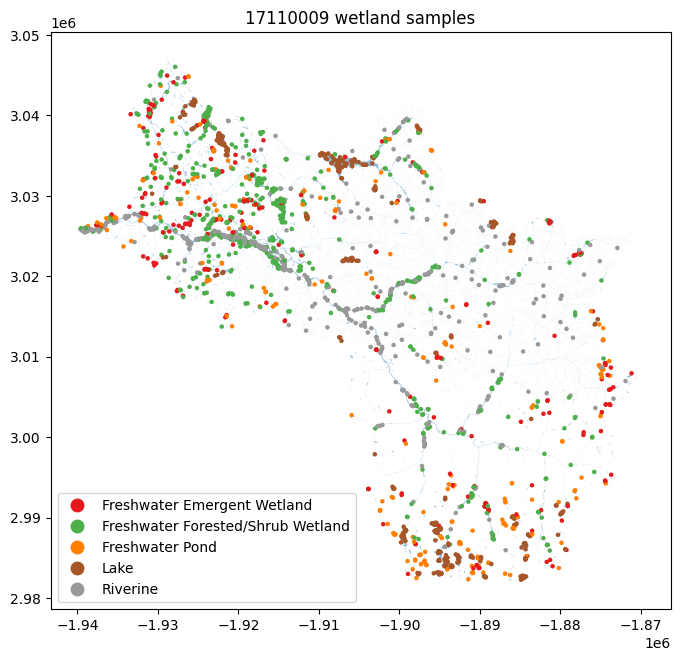

Number of points sampled for Freshwater Emergent Wetland: 252
Number of points sampled for Freshwater Forested/Shrub Wetland: 593
Number of points sampled for Freshwater Pond: 252
Number of points sampled for Lake: 363
Number of points sampled for Riverine: 540


In [6]:
# Wetland class column name
wetland_class_column = "WETLAND_TY"  # Modify this with your actual column name

# Define the total number of points to sample
total_points = 2000

# Get the unique classes within the wetland class column
unique_classes = wetland_inventory_gdf[wetland_class_column].unique()

# Assign a numerical ID to each unique class
class_id_mapping = {
    class_name: class_id for class_id, class_name in enumerate(unique_classes, start=1)
}

# Group polygons by the wetland class column
grouped = wetland_inventory_gdf.groupby(wetland_class_column)

# Calculate the total area of each stratum
strata_areas = grouped.apply(lambda x: x.area.sum())

# Calculate the proportion of the total area that each stratum represents
strata_props = strata_areas / strata_areas.sum()

# Calculate the weight factor based on the size of each polygon
strata_weights = strata_areas / strata_areas.max()

# Create an empty list to store the sampled points
wetland_points = []

# Create a dictionary to store the number of points sampled for each class
class_points_dict = {}

# Sample points from each stratum
for class_name, group in tqdm(grouped, total=len(grouped), desc="Sampling progress"):
    # Get the numerical ID for the current class
    class_id = class_id_mapping[class_name]

    # Calculate the number of points to sample for this stratum
    num_points = np.ceil(strata_props[class_name] * total_points).astype(int)

    # Check if the number of points to sample is less than a desired amount (e.g. 30 points)
    if num_points < 300:
        num_points = 300

    # Calculate the weight for this stratum based on the polygon's size
    weight = strata_weights[class_name]

    # Initialize a counter to keep track of the number of points sampled for this stratum
    points_sampled = 0

    # Repeat until we have sampled the desired number of points for this stratum
    while points_sampled < num_points:
        # Sample a random polygon from this stratum, considering the weight
        polygon = (
            group.sample(n=1, weights=group.geometry.area * weight).iloc[0].geometry
        )

        # Sample a random point within the bounding box of the polygon
        x_min, y_min, x_max, y_max = polygon.bounds
        x = np.random.uniform(x_min, x_max)
        y = np.random.uniform(y_min, y_max)
        point = (x, y)

        # Check if the point is within the polygon
        if polygon.contains(Point(point)):
            # Append the point coordinates with the class_id and class_name as a tuple
            wetland_points.append((point, class_id, class_name))
            points_sampled += 1

    # If we have more points than desired, remove the excess
    if len(wetland_points) > total_points:
        wetland_points = random.sample(wetland_points, total_points)

    # Store the number of points sampled for this class
    class_points_dict[class_name] = points_sampled

# Convert the points list to a GeoDataFrame
wetland_samples_gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(
        [p[0][0] for p in wetland_points], [p[0][1] for p in wetland_points]
    ),
    data={
        "class_id": [p[1] for p in wetland_points],
        "class_name": [p[2] for p in wetland_points],
    },  # Add class_id and class_name as columns
)

# Plot the wetland polygons and the sampled points
fig, ax = plt.subplots(figsize=(8, 8))
wetland_inventory_gdf.plot(ax=ax, alpha=0.5)
wetland_samples_gdf.plot(
    ax=ax, column="class_name", categorical=True, legend=True, cmap="Set1", markersize=5
)
plt.title(f"{prefix} wetland samples")
plt.show()

# Display the number of sampled points for each class after removing the excess
for class_name, num_points in class_points_dict.items():
    if class_name in wetland_samples_gdf["class_name"].unique():
        num_points_after_removal = (
            wetland_samples_gdf["class_name"] == class_name
        ).sum()
        print(f"Number of points sampled for {class_name}: {num_points_after_removal}")
    else:
        print(f"Number of points sampled for {class_name}: 0")

### Class balancing 
A challenge encountered during the labeling of training data is class imbalance, which refers to the uneven distribution of classes within the dataset. During model training, the algorithm aims to optimize its performance over all training data. Therefore, an imbalanced training dataset can lead to a biased model. For example, when faced with a minority class, the model is more likely to misclassify it as a majority class rather than the other way around. In some cases, the distribution of the training data is intentionally designed to mirror the true distribution of the classes, and the resulting predictions are expected to be biased against the infrequent class. Alternatively, accuracy requirements may differ for various classes, making it desirable to adjust the proportions of the training labels. This adjustment ensures that there are more training data points available for classes where commission error (false positive) is preferred over omission error (false negative).

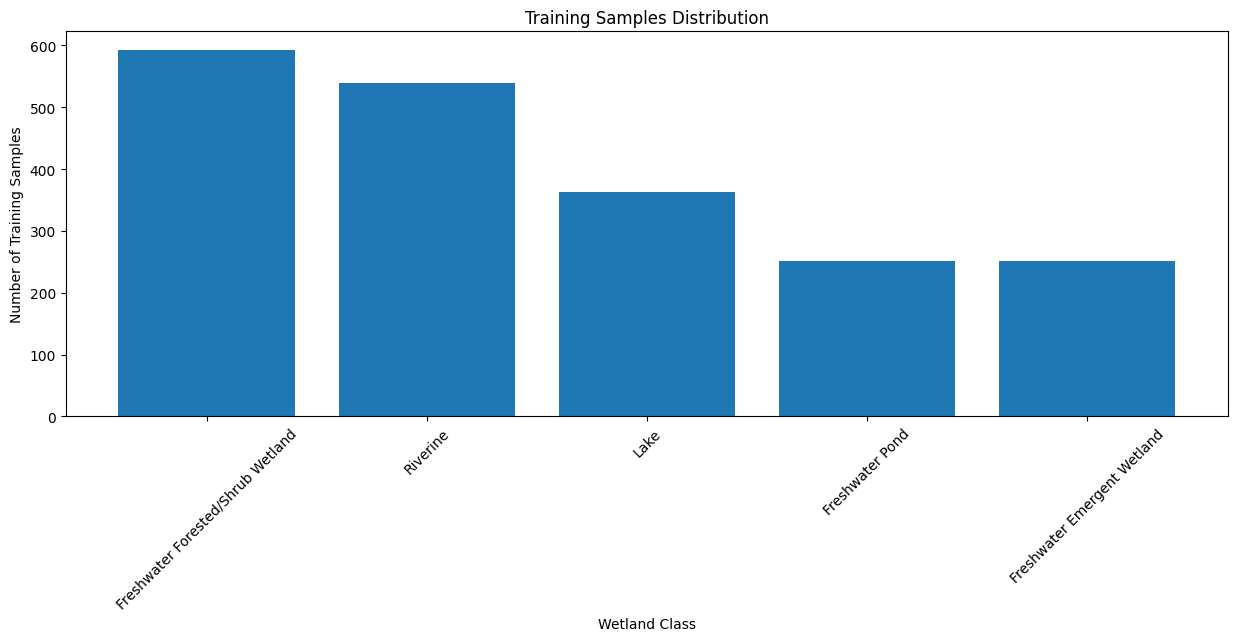

In [7]:
# Get unique class names from "class_name" column
class_names = wetland_samples_gdf["class_name"].unique()

# Count the number of samples for each wetland class
class_counts = wetland_samples_gdf["class_name"].value_counts()

# Plot training samples distribution
plt.figure(figsize=(15, 5))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Wetland Class")
plt.ylabel("Number of Training Samples")
plt.title("Training Samples Distribution")
plt.xticks(rotation=45)
plt.show()

We then reduce the number of samples for classes with significantly larger sample size than the other classes. In this case, we will allow sample size within 10 times the smallest sample.

No balancing needed
No balancing needed
No balancing needed
No balancing needed
No balancing needed


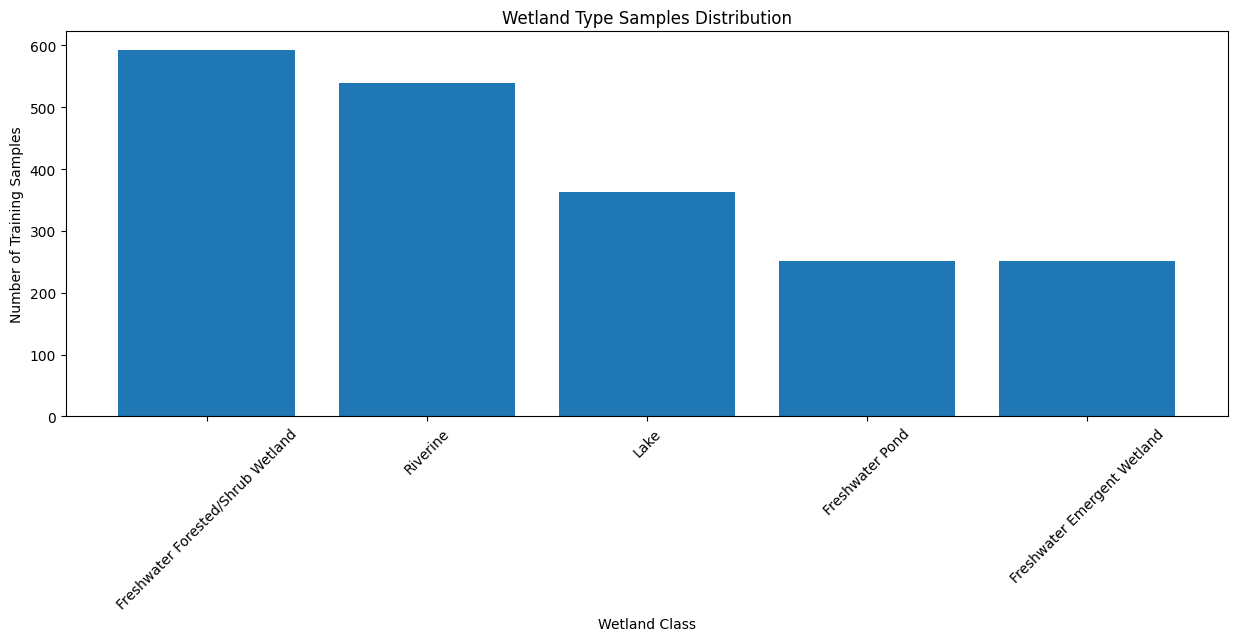

In [8]:
min_count = class_counts.min()
for class_name in class_counts.index:
    class_count = class_counts[class_name]
    if class_count > 10 * min_count:
        n_samples_dropped = class_count - 10 * min_count
        if n_samples_dropped > class_count:
            n_samples_dropped = class_count
        if n_samples_dropped >= class_count:
            print("No balancing needed for {}".format(class_name))
        else:
            print("Dropping {} of {} samples".format(n_samples_dropped, class_name))
            wetland_samples_gdf.drop(
                wetland_samples_gdf[wetland_samples_gdf["class_name"] == class_name]
                .sample(n=n_samples_dropped, replace=False)
                .index,
                axis=0,
                inplace=True,
            )
    else:
        print("No balancing needed")

# Update class_counts after balancing
class_counts = wetland_samples_gdf["class_name"].value_counts()

# Get class names
class_legends = [class_name for class_name in class_counts.index]

# Plot training samples distribution
plt.figure(figsize=(15, 5))
plt.bar(class_legends, class_counts.values)
plt.xlabel("Wetland Class")
plt.ylabel("Number of Training Samples")
plt.title("Wetland Type Samples Distribution")
plt.xticks(rotation=45)
plt.show()

### (Alternative) Sampling without wetland types
This code samples points uniformly within each individual wetland polygon, without considering the wetland class. It iterates over each polygon in the GeoDataFrame, samples a specified number of points (10 by default) uniformly within the bounding box of each polygon, and checks if the sampled points fall within the polygon. It repeats this process until the desired number of points is reached for each polygon.

In [9]:
# # Create an empty list to store the sampled points
# wetland_points = []
# total_points = 250

# # Iterate over all wetland polygons
# for polygon in tqdm(wetland_inventory_gdf.geometry,
#                     total=len(wetland_inventory_gdf),
#                     desc="Sampling progress"):
#     num_points = int(total_points / len(wetland_inventory_gdf))
#     points_sampled = 0

#     # Repeat until we have sampled the desired number of points for this polygon
#     while points_sampled < num_points:
#         # Sample a random point within the bounding box of the polygon
#         x_min, y_min, x_max, y_max = polygon.bounds
#         x = random.uniform(x_min, x_max)
#         y = random.uniform(y_min, y_max)
#         point = (x, y)

#         # Check if the point is within the polygon
#         if polygon.contains(Point(point)):
#             # Append the point coordinates
#             wetland_points.append(point)
#             points_sampled += 1

# # If the desired number of total points is not reached yet
# while len(wetland_points) < total_points:
#     # Randomly select a wetland polygon
#     polygon = random.choice(wetland_inventory_gdf.geometry)

#     # Sample a random point within the bounding box of the polygon
#     x_min, y_min, x_max, y_max = polygon.bounds
#     x = random.uniform(x_min, x_max)
#     y = random.uniform(y_min, y_max)
#     point = (x, y)

#     # Check if the point is within the polygon
#     if polygon.contains(Point(point)):
#         # Append the point coordinates
#         wetland_points.append(point)

# # Print the number of points sampled
# print(f"Number of points sampled: {len(wetland_points)}")

# # Convert the points list to a GeoDataFrame
# wetland_samples_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(
#     [p[0] for p in wetland_points], [p[1] for p in wetland_points]))

# # Add an ID column with a value of 1 to the GeoDataFrame
# wetland_samples_gdf["class_id"] = 1
# # Add a class name column with the value "wetland"
# wetland_samples_gdf["class_name"] = "Wetland"

# # Plot the wetland polygons and the sampled points
# fig, ax = plt.subplots(figsize=(8, 8))
# wetland_inventory_gdf.plot(ax=ax, alpha=0.5)
# wetland_samples_gdf.plot(ax=ax, color='Blue', markersize=5)
# plt.title("Randomly Sampled Points within Wetland Areas")
# plt.show()

### Non-wetland sampling

This code generates a set number of random points (specified by total_points) from within a single polygon representing non-wetland areas. It does this by repeatedly generating random points within the bounds of the polygon until the desired number of points is reached. The code checks each point to ensure that it is actually within the polygon, and keeps track of the number of points sampled using a progress bar. Finally, it prints the total number of points generated

100%|██████████| 3000/3000 [00:10<00:00, 295.28it/s]


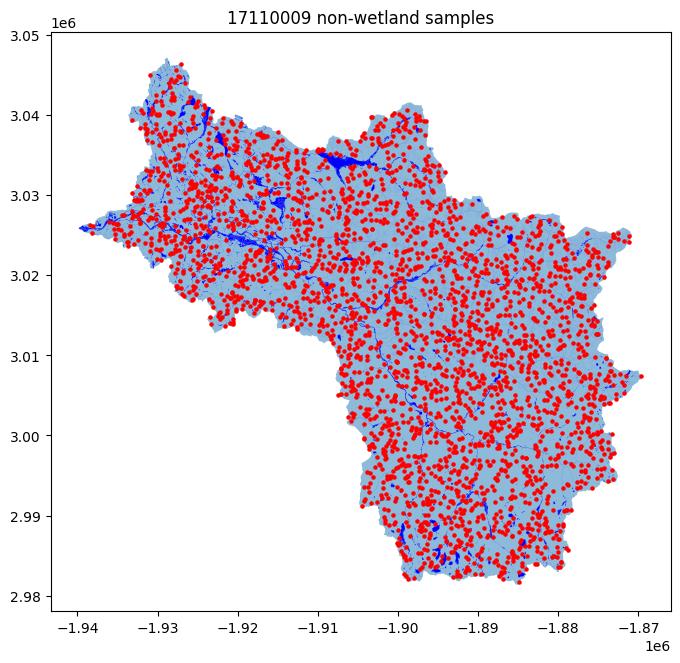

Total points sampled: 3000


In [10]:
# Set the total number of points to sample within the AOI
total_points = 3000

# Sample points from the AOI using simple random sampling
bounds = aoi_geopolygon_gdf.to_crs(nwi.crs).total_bounds

non_wetland_points = []
with tqdm(total=total_points) as pbar:  # set up the progress bar
    while len(non_wetland_points) < total_points:
        x = random.uniform(bounds[0], bounds[2])
        y = random.uniform(bounds[1], bounds[3])
        point = (x, y)

        # Check if the point is within the AOI and not in any wetland area
        if aoi_geopolygon_gdf.to_crs(nwi.crs).geometry[0].contains(
            Point(point)
        ) and not any(wetland_inventory_gdf.geometry.contains(Point(point))):
            non_wetland_points.append(point)
            pbar.update(1)  # update the progress bar

# Convert the points list to a GeoDataFrame
non_wetland_samples_gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(
        [p[0] for p in non_wetland_points], [p[1] for p in non_wetland_points]
    )
)

# Add an ID column with a value of 1 to the GeoDataFrame
non_wetland_samples_gdf["class_id"] = 0
# Add a class name column with the value "non-wetland"
non_wetland_samples_gdf["class_name"] = "Non-wetland"

# Plot the sampled points
fig, ax = plt.subplots(figsize=(8, 8))
aoi_geopolygon_gdf.to_crs(nwi.crs).plot(ax=ax, alpha=0.5)
wetland_inventory_gdf.plot(
    ax=ax, marker="o", color="blue", markersize=5, label="Wetland"
)
non_wetland_samples_gdf.plot(ax=ax, color="red", markersize=5)
plt.title(f"{prefix} non-wetland samples")
plt.show()

print(f"Total points sampled: {len(non_wetland_points)}")

## Combine wetland and non-wetland sample points

The wetland and non-wetland samples generated from the previous step are combined into a single dataset. This combined dataset will be used for training the wetland classification model. By including both wetland and non-wetland samples, the model can learn to distinguish and classify different types of wetlands accurately.

In [11]:
# Create a combined GeoDataFrame with wetland and non-wetland samples
combined_samples_gdf = pd.concat([wetland_samples_gdf, non_wetland_samples_gdf])
combined_samples_gdf

,class_id,class_name,geometry
0,4,Freshwater Pond,POINT (-1896985.616 3009893.207)
1,5,Lake,POINT (-1886003.02 3024683.236)
2,2,Freshwater Forested/Shrub Wetland,POINT (-1894638.609 3009737.394)
3,2,Freshwater Forested/Shrub Wetland,POINT (-1923049.55 3027025.495)
4,5,Lake,POINT (-1921414.971 3035278.664)
...,...,...,...
2995,0,Non-wetland,POINT (-1891478.303 3010568.287)
2996,0,Non-wetland,POINT (-1913781.377 3035306.014)
2997,0,Non-wetland,POINT (-1900113.117 2993594.631)
2998,0,Non-wetland,POINT (-1931057.309 3032967.145)


### Create a training and testing dataset

In [12]:
# Split the data into 80% training and 20% testing datasets
train_df, test_df = train_test_split(
    combined_samples_gdf, test_size=0.2, random_state=42
)

# Verify the shapes of the training and testing datasets
print("Training dataset shape:", train_df.shape)
print("Testing dataset shape:", test_df.shape)

Training dataset shape: (4000, 3)
Testing dataset shape: (1000, 3)


In [13]:
# Save the training samples GeoDataFrame as GeoJSON
train_df.set_crs(nwi.crs).to_crs(4326).to_file(
    f"/data/{prefix}_training_samples.geojson",
    driver="GeoJSON",
    crs=wetland_inventory_gdf.crs,
    engine="fiona",
)

# Save the testing samples GeoDataFrame as GeoJSON
test_df.set_crs(nwi.crs).to_crs(4326).to_file(
    f"/data/{prefix}_testing_samples.geojson",
    driver="GeoJSON",
    crs=wetland_inventory_gdf.crs,
    engine="fiona",
)

### Export class label dictionary 
By exporting the class label dictionary, you can store and access the mapping between class IDs and class names in a structured format. This can be useful for reference and future use, such as when interpreting model predictions or evaluating performance metrics.

In [14]:
# Get distinct ID and name combinations
distinct_labels = combined_samples_gdf[["class_id", "class_name"]].drop_duplicates()

# Create label dictionary
labels_dict = dict(zip(distinct_labels["class_name"], distinct_labels["class_id"]))

# Print the label dictionary
print(labels_dict)

# Get distinct ID and name combinations
distinct_labels = combined_samples_gdf[["class_id", "class_name"]].drop_duplicates()

# Create label dictionary
labels_dict = dict(zip(distinct_labels["class_name"], distinct_labels["class_id"]))

# Specify the file path where you want to save the JSON file
file_path = f"/data/{prefix}_labels_dict.json"

# Export the labels_dict as a JSON file
with open(file_path, "w") as json_file:
    json.dump(labels_dict, json_file)

# Print a confirmation message
print(f"The labels_dict has been exported as {file_path}.")

{'Freshwater Pond': 4, 'Lake': 5, 'Freshwater Forested/Shrub Wetland': 2, 'Riverine': 1, 'Freshwater Emergent Wetland': 3, 'Non-wetland': 0}
The labels_dict has been exported as /data/17110009_labels_dict.json.


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [15]:
from datetime import datetime

datetime.today().strftime("%Y-%m-%d")

'2025-07-09'